In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional
from torch.utils.data import DataLoader
from torchvision import utils
from torchvision.utils import save_image
from torchvision import transforms as T

import config
from dataset import (
    CompressedImageDataset,
    ImageDataset,
    cifar10,
    imagenet_mini,
)
from model import Classifier, Encoder

from compress import HyperpriorWrapper
from utils import load_checkpoint, norm, save_checkpoint, unnorm, plot

import pickle

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_WORKERS = 16
NUM_EPOCHS = 100

train_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        T.RandomHorizontalFlip(p=0.5),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

val_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [4]:
print(DEVICE)

# compressor = None
compressor = (
    HyperpriorWrapper(1, pretrained=True)
    .eval()
    .to(DEVICE)
)
# CH = 3 if compressor is None else 192

# model = Classifier(in_features=192*16*16, n_classes=10, hidden_layers=0, n_hidden=1024)
enc = Encoder(in_channels=192, n_features=1024).to(DEVICE)
clf = Classifier(in_features=2048).to(DEVICE)

model = nn.Sequential(enc, clf).to(DEVICE)
opt = optim.Adam(
    list(model.parameters()),
    lr=LEARNING_RATE
)

criterion = nn.CrossEntropyLoss()

cuda


In [5]:
# if config.LOAD_MODEL:
#     load_checkpoint(
#         "checkpoints/clf_cifar10_compress_53.pth", model, opt, config.LEARNING_RATE
#     )

In [6]:
dataset_train = ImageDataset(
    root=cifar10.train_root,
    transform=config.transform_train
)

dataset_val = ImageDataset(
    root=cifar10.val_root, transform=config.transform_val
)

In [7]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [8]:
@torch.no_grad()
def compress(x, co):
    compressed = co.compress(x)
    return co.entropy_decode(compressed["strings"], compressed["shape"])
    # return co.encode(x)


@torch.no_grad()
def decompress(y, co):
    return co.decode(y)
    # compressed = co.entropy_encode(y)
    # return co.decompress(compressed["strings"], compressed["shape"])

In [9]:
labels = dataset_train.labels

In [10]:
scaler = torch.cuda.amp.GradScaler()

In [11]:
from tqdm import tqdm


def train(epoch, model, dataloader, opt, criterion, co):
    progress = tqdm(
        dataloader, leave=True, desc=f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]"
    )
    log_step = len(dataloader) // 10

    losses = []
    acc = []

    model.train()
    for i, (x, y) in enumerate(progress):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        x = compress(x, co)
        with torch.cuda.amp.autocast():
            pred = model(x)
            loss = criterion(pred, y)

        opt.zero_grad()
        # loss.backward()
        scaler.scale(loss).backward()
        # opt.step()
        scaler.step(opt)
        scaler.update()

        losses.append(loss.item())
        acc.append((pred.argmax(dim=-1) == y).cpu().numpy().mean())

        progress.set_description(
            (
                f"train | epoch [{epoch+1}/{config.NUM_EPOCHS}] | "
                f"loss = {np.mean(losses):.3f} | "
                f"acc = {np.mean(acc):.3f} | "
            )
        )

        if i % log_step == 0:
            x = decompress(x, co)
            x = x[0]
            y = pred.argmax(dim=-1)[0]
            label = labels[y]
            save_image(x, f"results/{epoch}_{i//log_step}_{label}.png")

    return losses


def val(epoch, model, dataloader, criterion, co):
    progress = tqdm(
        dataloader, leave=True, desc=f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]"
    )
    log_step = len(dataloader) // 10

    losses = []
    acc = []

    model.eval()
    for i, (x, y) in enumerate(progress):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        x = compress(x, co)

        pred = model(x)

        loss = criterion(pred, y)

        losses.append(loss.item())
        acc.append((pred.argmax(dim=-1) == y).cpu().numpy().mean())

        progress.set_description(
            (
                f"val | epoch [{epoch+1}/{config.NUM_EPOCHS}] | "
                f"loss = {np.mean(losses):.3f} | "
                f"acc = {np.mean(acc):.3f} | "
            )
        )

        if i == 0:
            x = decompress(x, co)
            x = x[0]
            y = pred.argmax(dim=-1)[0]
            label = labels[y]
            save_image(x, f"results/{epoch}_val_{label}.png")
    return losses

In [12]:
from utils import save_checkpoint

Epoch [1/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/100]:   0%|          | 0/313 [00:00<?, ?it/s]

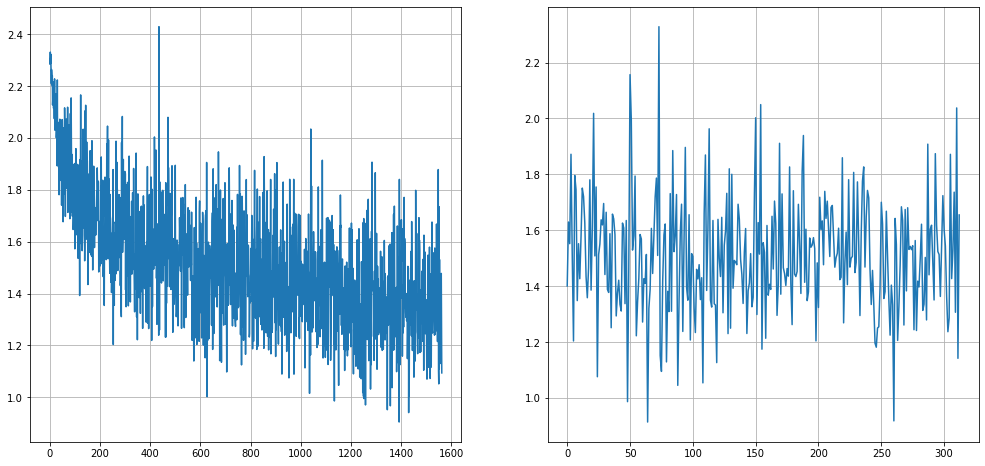

=> Saving checkpoint


Epoch [2/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/100]:   0%|          | 0/313 [00:00<?, ?it/s]

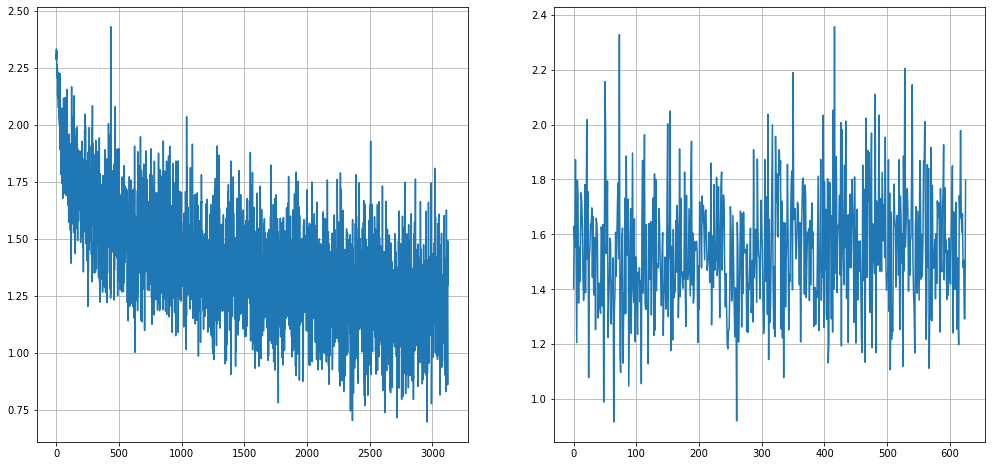

=> Saving checkpoint


Epoch [3/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/100]:   0%|          | 0/313 [00:00<?, ?it/s]

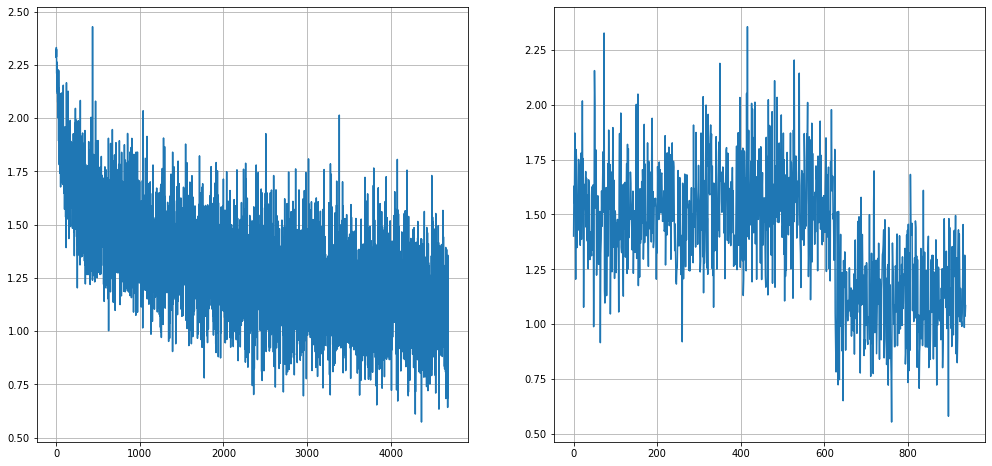

=> Saving checkpoint


Epoch [4/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/100]:   0%|          | 0/313 [00:00<?, ?it/s]

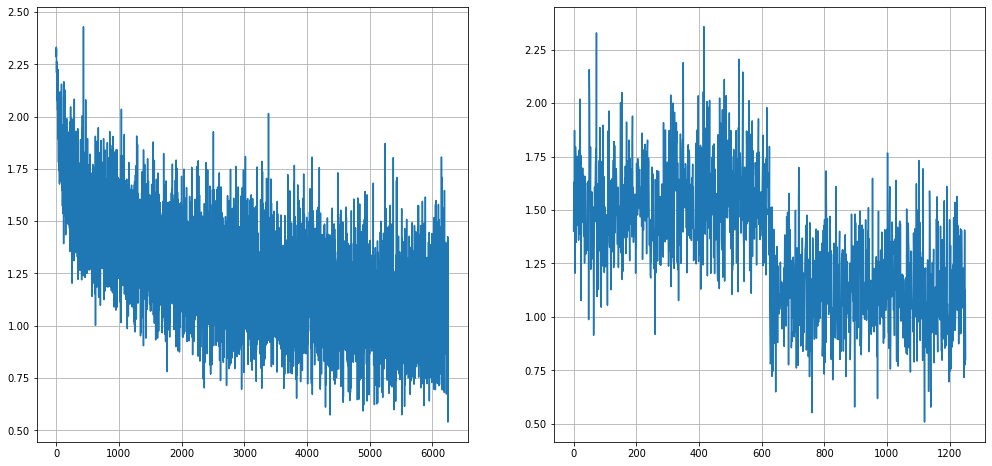

=> Saving checkpoint


Epoch [5/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/100]:   0%|          | 0/313 [00:00<?, ?it/s]

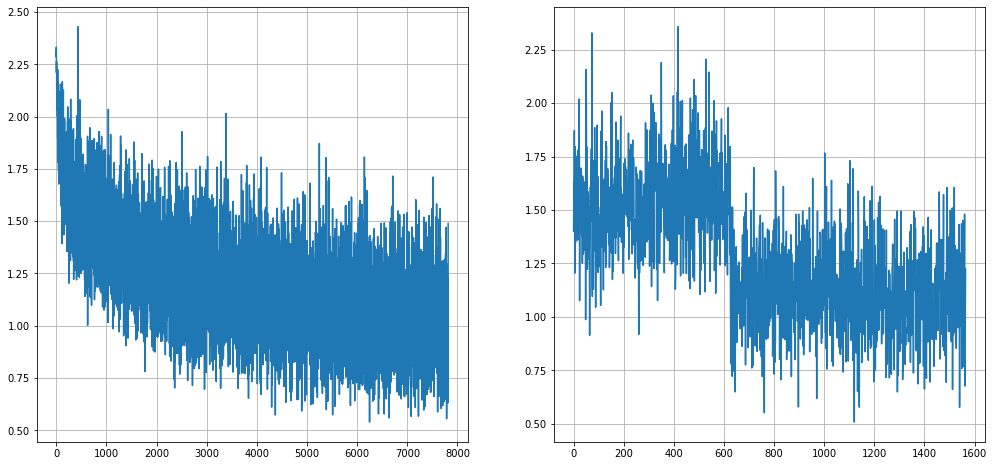

=> Saving checkpoint


Epoch [6/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [6/100]:   0%|          | 0/313 [00:00<?, ?it/s]

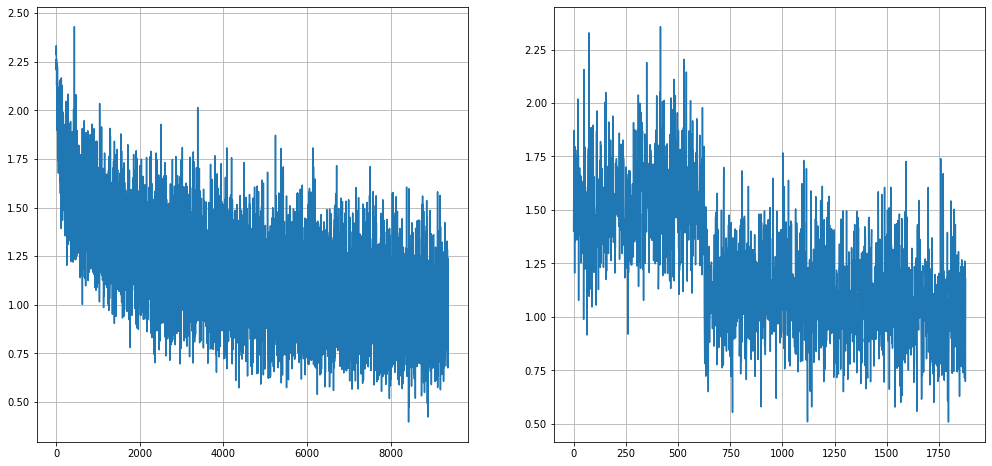

=> Saving checkpoint


Epoch [7/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [7/100]:   0%|          | 0/313 [00:00<?, ?it/s]

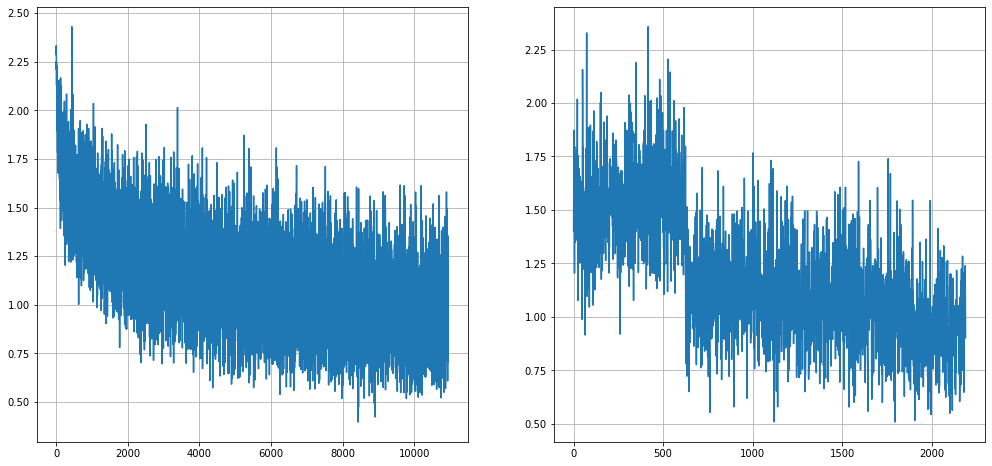

=> Saving checkpoint


Epoch [8/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [8/100]:   0%|          | 0/313 [00:00<?, ?it/s]

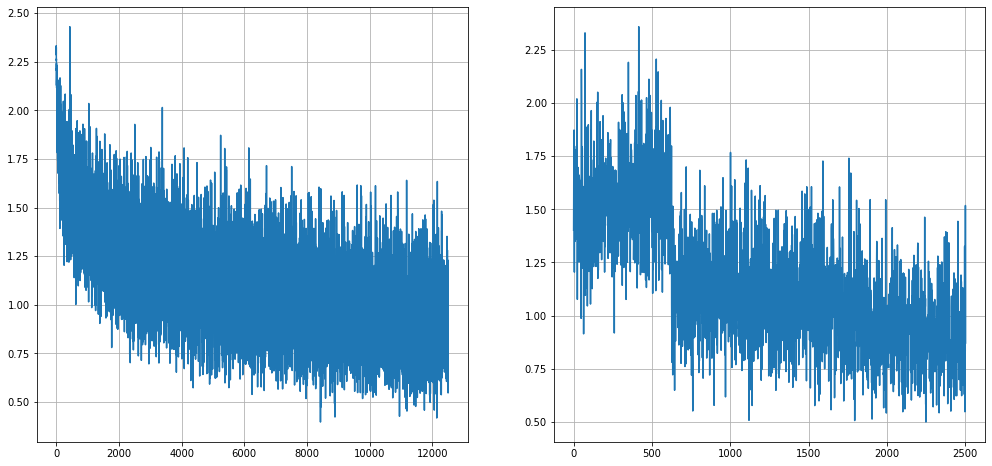

=> Saving checkpoint


Epoch [9/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [9/100]:   0%|          | 0/313 [00:00<?, ?it/s]

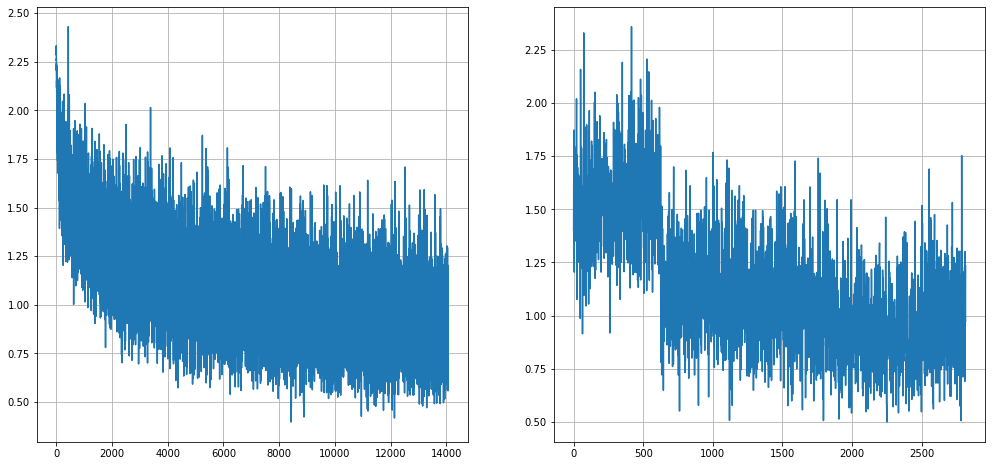

=> Saving checkpoint


Epoch [10/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [10/100]:   0%|          | 0/313 [00:00<?, ?it/s]

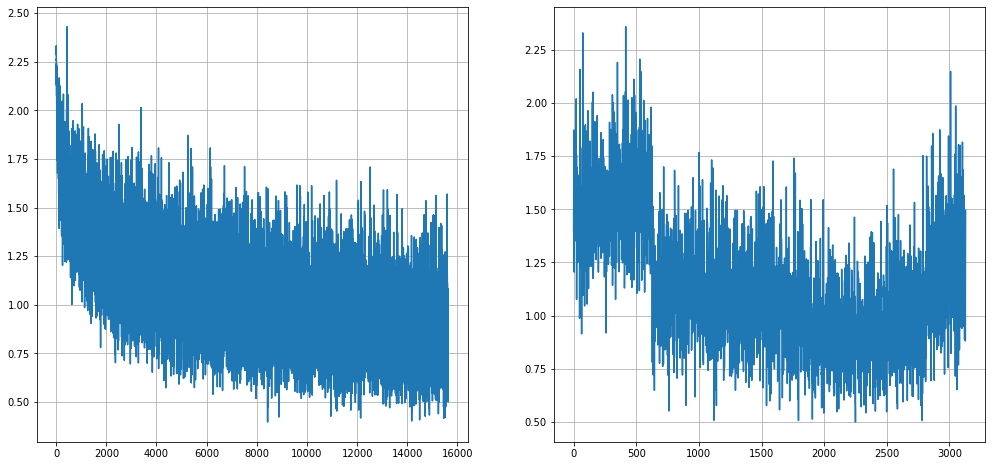

=> Saving checkpoint


Epoch [11/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [11/100]:   0%|          | 0/313 [00:00<?, ?it/s]

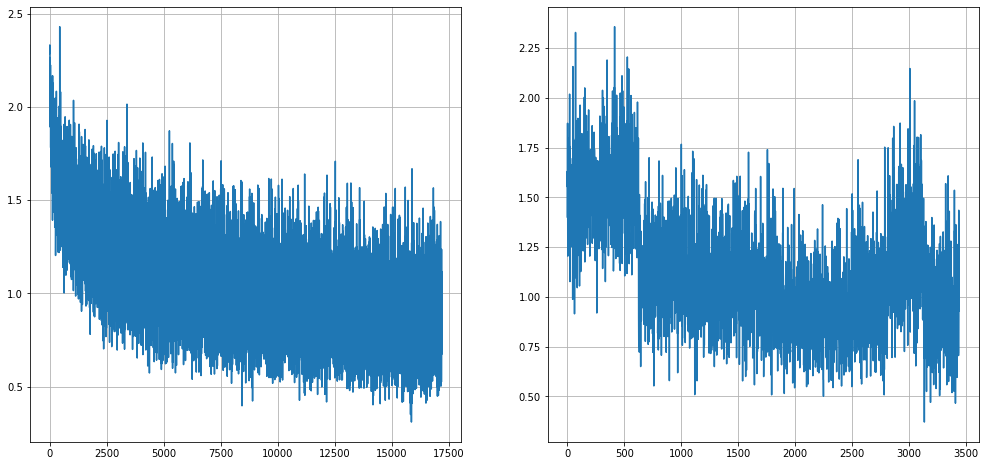

=> Saving checkpoint


Epoch [12/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [12/100]:   0%|          | 0/313 [00:00<?, ?it/s]

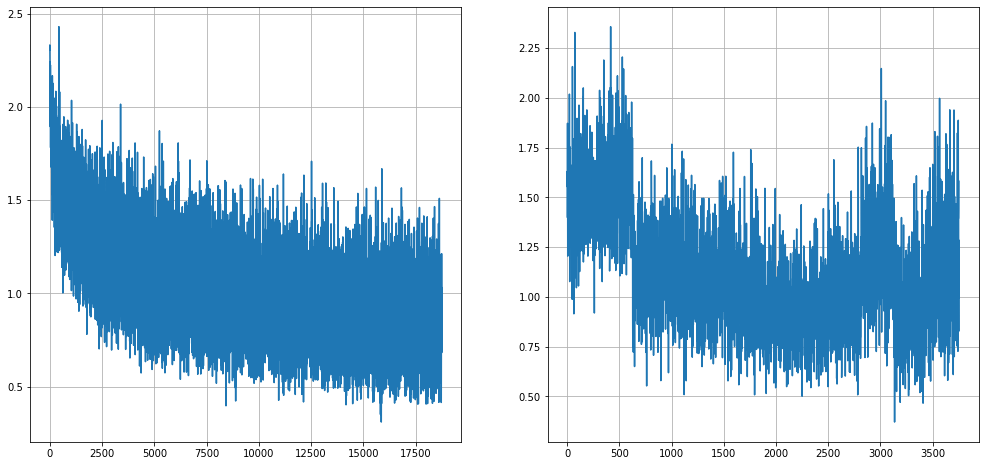

=> Saving checkpoint


Epoch [13/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [13/100]:   0%|          | 0/313 [00:00<?, ?it/s]

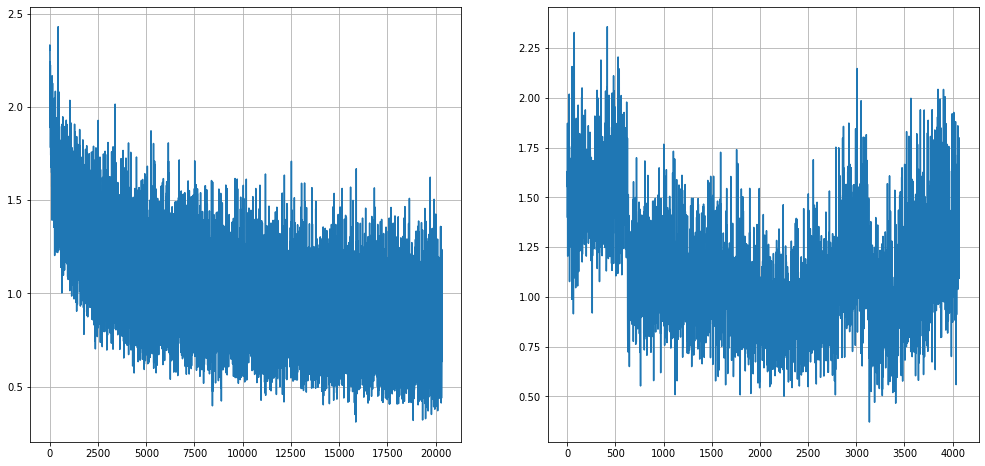

=> Saving checkpoint


Epoch [14/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [14/100]:   0%|          | 0/313 [00:00<?, ?it/s]

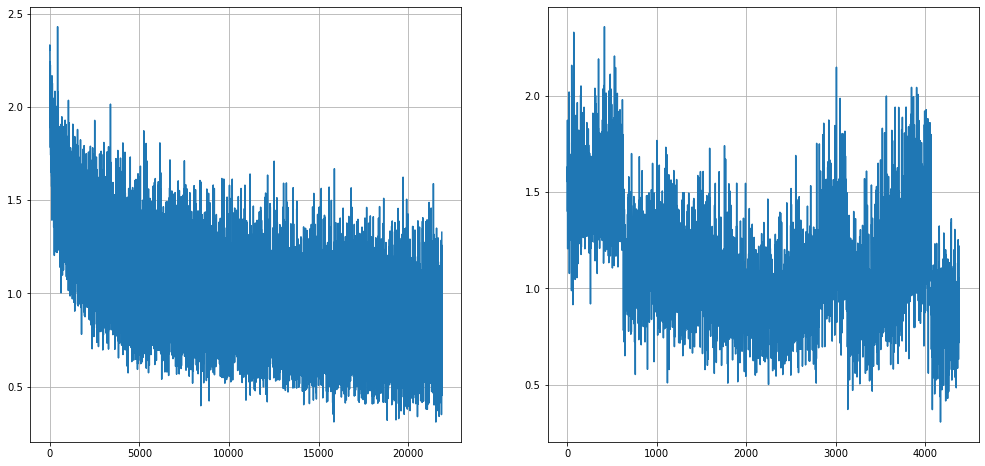

=> Saving checkpoint


Epoch [15/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [15/100]:   0%|          | 0/313 [00:00<?, ?it/s]

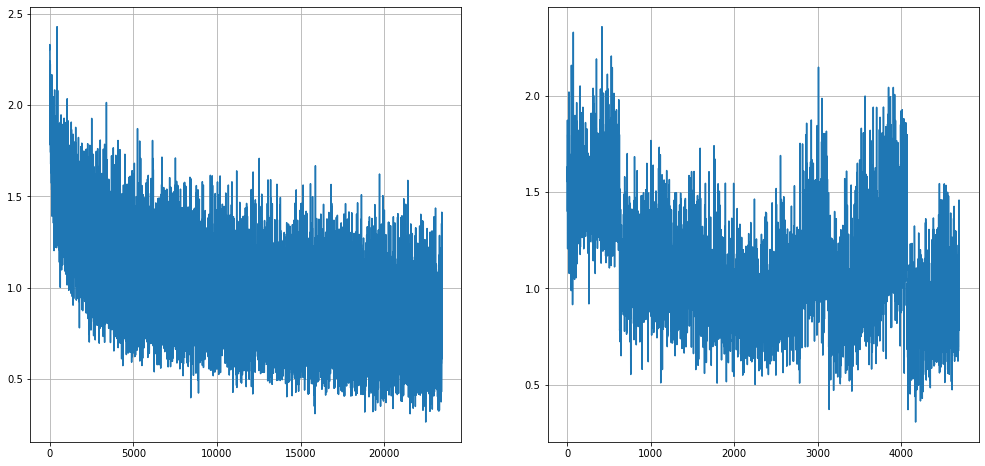

=> Saving checkpoint


Epoch [16/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [16/100]:   0%|          | 0/313 [00:00<?, ?it/s]

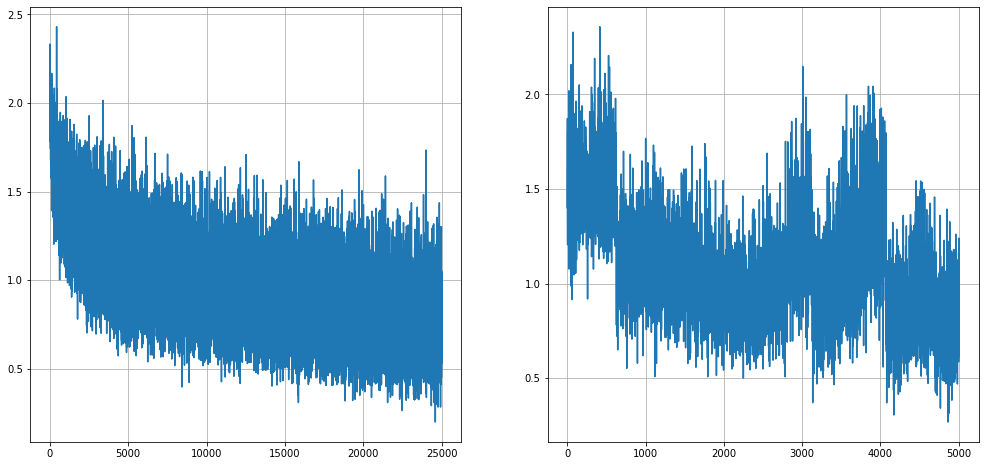

=> Saving checkpoint


Epoch [17/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [17/100]:   0%|          | 0/313 [00:00<?, ?it/s]

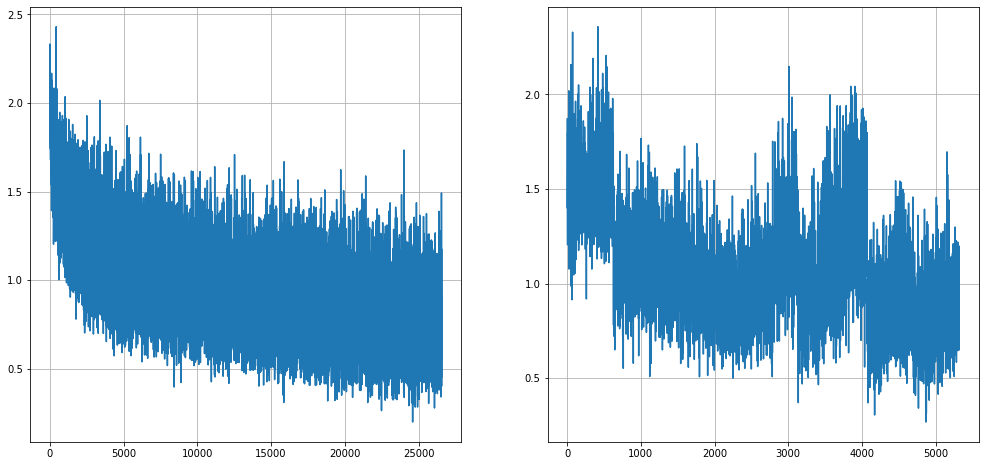

=> Saving checkpoint


Epoch [18/100]:   0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
from tqdm.notebook import tqdm

train_loss_history = []
val_loss_history = []
for epoch in range(NUM_EPOCHS):
    train_losses = train(epoch, model, dataloader_train, opt, criterion, compressor)
    train_loss_history.extend(train_losses)

    val_losses = val(epoch, model, dataloader_val, criterion, compressor)
    val_loss_history.extend(val_losses)

    plot(train_loss_history, val_loss_history)
    
    save_checkpoint(model, opt, "checkpoints/clf_cifar10_compress.pth")

In [25]:
# save_checkpoint(model, opt, "checkpoints/clf_cifar10_compress_53.pth")

=> Saving checkpoint


In [8]:
from compress import HyperpriorWrapper

compressor = HyperpriorWrapper(1, pretrained=True).eval().to(DEVICE)

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

torch.Size([16])


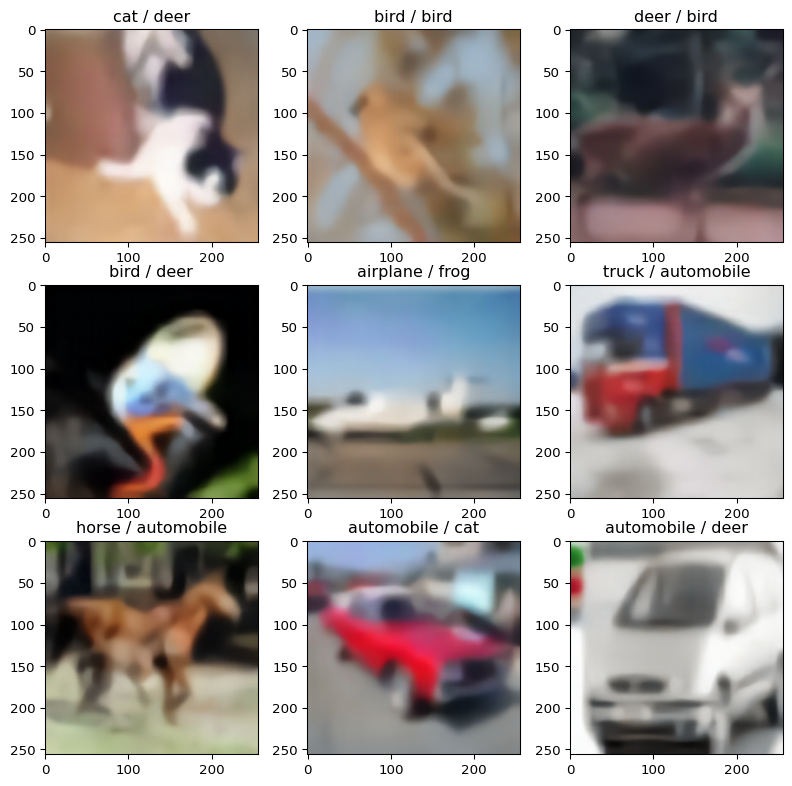

In [11]:
images, labels = iter(dataloader_val).next()
images = images.to(DEVICE)
compressed = compressor.compress(images)
decoded = compressor.entropy_decode(compressed["strings"], compressed["shape"])
decompressed = compressor.decode(decoded)
out = model(decoded)
pred = out.argmax(dim=-1)
print(pred.shape)
plt.figure(figsize=(10, 10), dpi=96)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = T.ToPILImage()(decompressed[i])
    label_p = dataset_val.labels[pred[i].item()]
    label_t= dataset_val.labels[labels[i].item()]
    plt.imshow(image)
    plt.title(label_t + " / " + label_p)